# Find MSLP analogues of ERA5 event 

- selects desired precipitation event
- searches for analogues in ERA5 dataset
- searches for analogues in CRCM5 Large Ensemble

### Packages and Directories

In [1]:
# --- Imports ---
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, LocalCluster
from scipy.interpolate import griddata
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Custom Functions ---
# sys.path.append('/home/portal/script/python/precip_Cristina/')                    # tintin
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python/precip_Cristina')   # alice
import functions_analogues_PrMax as fanPM
import functions_analogues_LUCAFAMOSS as fan

In [2]:
# Define directories for data and figures
# # tintin
# CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
# ERA5_dir = '/work_big/users/clima/portal/ERA5/'
# CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'
# fig_dir = '/home/portal/figures/case-studies_byNode/'

# alice
CERRA_dir = '/media/alice/Crucial X9/portal/data_CNR/CERRA/'
ERA5_dir = '/media/alice/Crucial X9/portal/data_CNR/ERA5/'
CRCM5_dir = '/media/alice/Crucial X9/portal/data_CNR/CRCM5-LE/'
fig_dir = '/home/alice/Desktop/CNR/ENCIRCLE/materiale_alice/figures/analogues/'

### Identifies event in time and space

In [3]:
# Event selection
lselect = 'alert-regions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 6
no_event = 19
# Upload the data
if lselect == 'wide-region':
    df_events = pd.read_excel(CERRA_dir+'events_on_wide_regions.xlsx', sheet_name=no_node-1)
elif lselect == 'alert-regions':
    df_events = pd.read_excel(CERRA_dir+'events_cum_on_above99_alertregions_CERRA.xlsx', sheet_name=no_node-1)
elif lselect == 'Italy':
    df_events = pd.read_excel(CERRA_dir+'events_on_Italy.xlsx', sheet_name=no_node-1)
time_event = df_events['Time'].iloc[no_event-1] + pd.Timedelta('12h')
doy_event =  time_event.timetuple().tm_yday
# Define lon-lat box of event
box_event = fanPM.box_event_PrMax_alertregions(no_node,no_event)

# Event information
print('Event time:', time_event)
print('Event DOY:', doy_event)
print('Event box:', box_event)

Event time: 1996-10-08 18:00:00
Event DOY: 282
Event box: [2, 20, 33, 48]


In [4]:
# Defines the months for analogue selection
month_event = time_event.month
months_sel = [month_event-1, month_event, month_event+1]
# Get the month names
month_names = [calendar.month_abbr[month] for month in months_sel]
# Extract the initials
str_months = ''.join([name[0] for name in month_names])

# Months for analogue selection
print('Season (selection of 3 months) for analogue search:', str_months)

Season (selection of 3 months) for analogue search: SON


### Upload event data in ERA5 (anom & clim)

In [5]:
# Upload event mslp data
dmslp_event = fanPM.load_ERA5_data('mslp', 'daily', time_event, box_event, l_anom=True, data_dir=ERA5_dir+'mslp/')
mslp_clim = fanPM.load_ERA5_clim('mslp', doy_event, box_event, l_smoothing=True, data_dir=ERA5_dir+'mslp/climatology/')

#### Plot event field

/tmp/ipykernel_12237/49627513.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


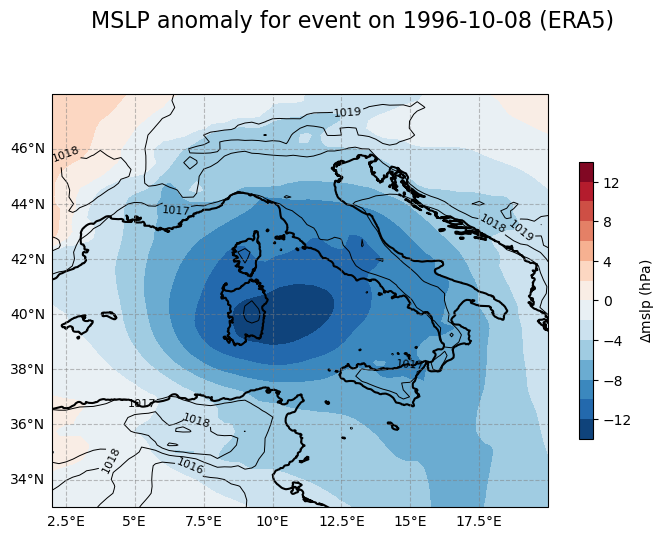

In [6]:
# Plot event
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
fanPM.plot_anom_event(ax, "mslp", dmslp_event.longitude, dmslp_event.latitude, dmslp_event.values, mslp_clim)
fig.suptitle("MSLP anomaly for event on "+str(time_event)[:10]+" (ERA5)", fontsize=16)
fig.show()
fig.savefig(fig_dir+'mslp_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_box-analogues.png')

#### Select ERA5 event data to event box at 0.5 resolution

In [7]:
dmslp_event_regridded = fanPM.regrid_with_xesmf(dmslp_event, box_event, resolution=0.5)
mslp_clim_regridded = fanPM.regrid_with_xesmf(mslp_clim, box_event, resolution=0.5)

/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


## Find analogues in ERA5

### Parameters of data selection

In [8]:
# Variable
varname = 'mslp'
# Time
year_range = [2004, 2023]
years_sel = np.arange(year_range[0], year_range[1]+1)

### Load and preprocess data for analogue search

In [9]:
# Define the file pattern for loading mslp data
file_pattern = ERA5_dir + varname +"/res05/ERA5_"+varname+"_NH_daily_*_anom_regridded-to-CRCM5.nc"
dmslp_tmp = xr.open_mfdataset(file_pattern, combine='by_coords', parallel=True)['msl'] * 0.01
dmslp_tmp = dmslp_tmp.sel(time=dmslp_tmp.time.dt.month.isin(months_sel))
dmslp_tmp = dmslp_tmp.sel(time=dmslp_tmp.time.dt.year.isin(years_sel))

# Define and select lon lat masks (specific of each event)
lon_mask, lat_mask = fanPM.lonlat_mask(dmslp_tmp.lon.values, dmslp_tmp.lat.values, box_event)
mask = lat_mask[:, np.newaxis] & lon_mask
mask_xr = xr.DataArray(
    mask,
    dims=["lat", "lon"],
    coords={"lat": dmslp_tmp.lat, "lon": dmslp_tmp.lon},
)

# Apply mask to the dataset
dmslp_sel = dmslp_tmp.where(mask_xr, drop=True)

### Quantile selection

In [10]:
# Quantile
qtl = 0.99
# Fix number of analogues based on the quantile
n_analogues = int(np.round(len(dmslp_sel.time) * (1-qtl)))
print('Number of analogues to be selected:', n_analogues)
# Minimum spacing between analogues
analogue_spacing = 7 # days

Number of analogues to be selected: 18


### Compute Euclidean distance from event

In [11]:
# Compute euclidean distance from the event to the selected mslp data
dist = fan.function_distance(dmslp_event_regridded, dmslp_sel, nan_version=True)

### Analogue selection

1. Identify a large pool of analogues using qtl_0sel

2. Exclude analogues within ±7 days of their associated event

3. Select analogues with >=7-day spacing between them (keeping best n_analogues, i.e. 1st percentile of days after analogue filtering)

4. Average selected analogues, if at least n_analogues have been selected

In [12]:
# First search of n_analogues
factor_0sel = 2
qtl_0sel = 1 - ((1 - qtl) * factor_0sel)  # First selection of the quantile, for extracting a total of n_analogues
l_0sel = True  # Flag for selection of analogues

while l_0sel:
    # Compute log-transformed distance
    logdist = np.log(1 / dist)
    # Threshold at given quantile 0sel
    thresh_0sel = np.percentile(logdist, qtl_0sel * 100, axis=0)
    mask_analogues = logdist >= thresh_0sel
    
    # Event time, all times and required time spacing
    all_times = dmslp_sel.time.values
    event_time = dmslp_event.time.values
    
    # Exclude analogue times within ±7 days of their associated event
    time_diff = np.abs((all_times - event_time).astype('timedelta64[D]').astype(int))
    mask_analogues &= np.array(time_diff) >= analogue_spacing  # update mask to exclude times too close to the event
    indices_analogues = np.where(mask_analogues)[0]  # indices of all valid analogue times
    
    # Filter analogues based on the mask and logdist, ensuring they are spaced correctly (analogue_spacing days apart)
    indices_filtered_analogues = fan.timefilter_analogues(indices_analogues, logdist, all_times, analogue_spacing)

    if len(indices_filtered_analogues)>=n_analogues:
        indices_filtered_analogues = indices_filtered_analogues[:n_analogues]  # Select the first n_analogues (corresponding to the quantile qtl)
        l_0sel = False
        print("Selection completed using pool data from quantile", qtl_0sel)
    else:
        factor_0sel +=1
        qtl_0sel = 1 - ((1 - qtl) * factor_0sel)
    
# Save distance and times of selected analogues
listdistances = dist[indices_filtered_analogues]
listtimes = dmslp_sel.time.values[indices_filtered_analogues]
np.savez(f"./analogue_data/times_distances_analogues-{varname}_node{no_node}-extreme{no_event}-alertregions_{int(qtl*100)}pct_{year_range[0]}-{year_range[1]}_ERA5.npz", 
             times=listtimes, 
             distances=listdistances)

# Select and average
thresh = dist[indices_filtered_analogues[-1]]
dmslp_analogues = dmslp_sel.isel(time=indices_filtered_analogues) 
dmslp_analogues_mean = dmslp_analogues.mean(dim='time')
dmslp_analogues_mean_values = dmslp_analogues_mean.values

Selection completed using pool data from quantile 0.98


In [13]:
# Print the selected analogue times
print("Selected "+str(n_analogues)+" analogue times:\n", all_times[indices_filtered_analogues])
print('Threshold distance', thresh)

Selected 18 analogue times:
 [cftime.DatetimeNoLeap(2010, 11, 2, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2009, 10, 2, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2019, 10, 7, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2012, 9, 15, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2023, 11, 21, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2017, 11, 6, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2016, 10, 11, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2008, 9, 14, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2004, 11, 7, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2005, 9, 18, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2007, 10, 30, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2021, 11, 22, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2007, 9, 26, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2010, 10, 17, 9, 0, 0, 0, has_year_zero=True)
 cftime.Dateti

#### Optional: climatology from ERA5 analogue selection

In [14]:
doy_analogues = dmslp_analogues['time'].dt.dayofyear # day-of-year (DOY) from each analogue date
clim_analogues_sum = None # Initialize sum of climatology fields

# Loop through each DOY and accumulate corresponding climatology
for i, doy in enumerate(doy_analogues):
    # Load climatology for the specific DOY
    clim_day = fanPM.load_ERA5_clim('mslp', doy.item(), box_event, l_smoothing=True, data_dir=ERA5_dir+'mslp/climatology/').squeeze()

    # Accumulate climatology
    if i == 0:
        clim_analogues_sum = clim_day
    else:
        clim_analogues_sum += clim_day

# Compute average climatology over all analogue dates
clim_analogues = clim_analogues_sum / len(doy_analogues)
clim_analogues_regridded = fanPM.regrid_with_xesmf(clim_analogues, box_event, resolution=0.5) # Regrid to the desired resolution


/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


#### Compute mean on ERA5 analogues

/tmp/ipykernel_12237/9516024.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


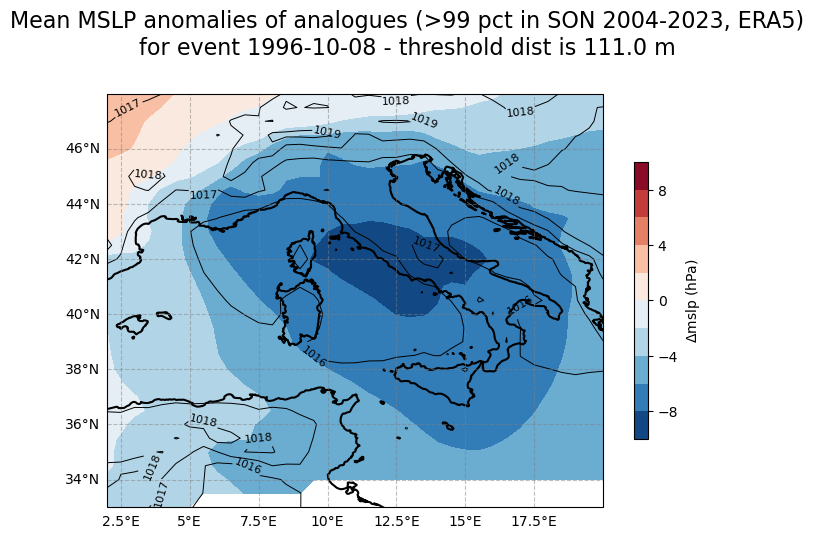

In [15]:
# Plot analogue mean
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
fanPM.plot_anom_event(ax, "mslp", dmslp_analogues_mean.lon, dmslp_analogues_mean.lat, dmslp_analogues_mean_values, clim_analogues_regridded)

fig.suptitle("Mean MSLP anomalies of analogues (>"+str(int(qtl*100))+" pct in "+str_months+' '+str(year_range[0])+'-'+str(year_range[1])+", ERA5)\nfor event "+str(time_event)[:10]+\
             " - threshold dist is "+str(np.round(thresh))+" m", fontsize=16)
fig.show()
fig.savefig(fig_dir+'analogues-mslp_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_mean_'+str(int(qtl*100))+'pct_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_ERA5.png')

## Find analogues in CRCM5

### Parameters of data selection

In [13]:
# Variable
varname = 'psl'
# Time
year_range = [2004, 2023] # past [1955-1974], present [2004-2023], near-future [2030-2049], far future [2080-2099]
month_event = time_event.month
years_sel = np.arange(year_range[0], year_range[1]+1)
months_sel = [month_event-1, month_event, month_event+1]
# Number of members to select
no_membs = 1 

### File paths per member

In [ ]:
# List of members
list_membs = [name for name in os.listdir(CRCM5_dir + varname) if os.path.isdir(os.path.join(CRCM5_dir + varname, name))]
list_membs = sorted(list_membs)[:no_membs]  # Select the first 'no_membs' members

# List file paths (anomalies and climatology)
memb_files, memb_files_clim = fanPM.get_anomaly_climatology_paths_CRCM5(CRCM5_dir, varname, list_membs, year_range)

### Open CRCM5 data

In [15]:
# Make list of datasets and add 'member' coordinate
list_ds = fanPM.open_member_datasets(memb_files, combine='by_coords', expand_member_dim=True)
list_ds_clim = fanPM.open_member_datasets(memb_files_clim, combine='by_coords', expand_member_dim=True)
# ??? Can.t open in parallel (gives error) 

# Concatenate and scale
dmslp_tmp_LE = xr.concat(list_ds, dim='member')[varname] * 0.01
mslp_tmp_clim_LE = xr.concat(list_ds_clim, dim='member')[varname] * 0.01

Opening files for member: kbg
Opening files for member: kbg


### Preprocess data

In [16]:
# Select the time range for the event
dmslp_tmp_LE = dmslp_tmp_LE.sel(time=dmslp_tmp_LE.time.dt.month.isin(months_sel))
dmslp_tmp_LE = dmslp_tmp_LE.sel(time=dmslp_tmp_LE.time.dt.year.isin(years_sel))
mslp_tmp_clim_LE = mslp_tmp_clim_LE.sel(time=mslp_tmp_clim_LE.time.dt.month.isin(months_sel))

# Select lon lat mask for the event
lon_mask_LE, lat_mask_LE = fanPM.lonlat_mask(dmslp_tmp_LE.lon.values, dmslp_tmp_LE.lat.values, box_event)
mask_LE = lat_mask_LE[:, np.newaxis] & lon_mask_LE
mask_xr_LE = xr.DataArray(
    mask_LE,
    dims=["lat", "lon"],
    coords={"lat": dmslp_tmp_LE.lat.values, "lon": dmslp_tmp_LE.lon.values},
)
dmslp_sel_LE = dmslp_tmp_LE.where(mask_xr_LE, drop=True)
mslp_sel_clim_LE = mslp_tmp_clim_LE.where(mask_xr_LE, drop=True)

### Select quantile

In [17]:
# Quantile
qtl_LE = 0.99
# Fix number of analogues per member based on the quantile
n_analogues_LE = int(np.round(len(dmslp_sel_LE.time) * (1-qtl_LE)))
print('Number of analogues to be selected:', n_analogues_LE)
# Minimum analogue spacing within same member
analogue_spacing_memb = 7 # days

Number of analogues to be selected: 18


### Compute Euclidean distance from ERA5 event

In [18]:
dist_LE = []  # Initialize an empty list to store distances for each member
for ii, memb in enumerate(list_membs):
    print('Computing distance for member:', memb)
    # Compute euclidean distance from the event to the selected mslp data for each member
    dist_memb = fan.function_distance(dmslp_event_regridded, dmslp_sel_LE.sel(member=memb), nan_version=True)
    dist_LE.append(dist_memb)

Computing distance for member: kbg


### Select analogues per member

In [19]:
list_dmslp_analogues_LE = []  # Initialize an empty list to store analogue data for each member
dmslp_analogues_membmean_LE = []  # Initialize an empty list to store mean analogue data for each member
indices_filtered_analogues_LE = []  # Initialize an empty list to store filtered indices for each member
thresh_LE = [] # Initialise an empty list to store threshold distance for each member
# Time values
all_times_LE = dmslp_sel_LE.time.values

# Find analogue indices for each member
for ii, memb in enumerate(list_membs):
    print('Processing member:', memb)

    # First search of n_analogues
    factor_0sel = 2
    qtl_0sel = 1 - ((1 - qtl_LE) * factor_0sel)  # First selection of the quantile, for extracting a total of n_analogues
    l_0sel = True  # Flag for selection of analogues
    
    while l_0sel:
        # Compute log-transformed distance
        logdist_memb = np.log(1 / dist_LE[ii])
        # Threshold at given quantile
        thresh_0sel = np.percentile(logdist_memb, qtl_0sel * 100, axis=0)
        mask_analogues_memb = (logdist_memb >= thresh_0sel)
        indices_analogues_memb = np.where(mask_analogues_memb)[0]  # indices of all valid analogue times
    
        # Filter analogues based on the mask and logdist, ensuring they are spaced correctly (analogue_spacing days apart)
        indices_filtered_analogues_memb = fan.timefilter_analogues(indices_analogues_memb, logdist_memb, all_times_LE, analogue_spacing_memb)

        if len(indices_filtered_analogues_memb) >= n_analogues_LE:
            indices_filtered_analogues_memb = indices_filtered_analogues_memb[:n_analogues_LE]
            l_0sel = False
            print("Selection completed using pool data from quantile", qtl_0sel)
        else:
            factor_0sel +=1
            qtl_0sel = 1 - ((1 - qtl_LE) * factor_0sel)
            
    # Save data in lists
    indices_filtered_analogues_LE.append(indices_filtered_analogues_memb)
    thresh_LE.append(dist_LE[ii][indices_filtered_analogues_memb[-1]])
    list_dmslp_analogues_LE.append(dmslp_sel_LE.isel(member=ii, time=indices_filtered_analogues_memb))
    dmslp_analogues_membmean_LE.append(list_dmslp_analogues_LE[-1].mean(dim='time'))
# Transfer list to array 
dmslp_analogues_membmean_LE = xr.concat(dmslp_analogues_membmean_LE, dim='member')
thresh_LE = np.array(thresh_LE)

Processing member: kbg
Selection completed using pool data from quantile 0.97


#### Optional: climatology from analogue selection

In [20]:
# # Apply mask to find matching analogues
# analogues_indices = np.where(mask_analogues_LE)[0]
# analogues_coords = dmslp_sel_LE_stacked.member_time[analogues_indices]
clim_analogues_LE = []  # Initialize an empty list to store analogue clim per member
doy_clim = mslp_sel_clim_LE['time'].dt.dayofyear

for ii, memb in enumerate(list_membs):
    time_values = list_dmslp_analogues_LE[ii].time
    doy_values = time_values.dt.dayofyear.values

    i_loop = 0
    for doy in doy_values:
        # Select for specific member and matching DOY
        mask_time = doy_clim == doy
        if i_loop == 0:
            clim_memb = mslp_sel_clim_LE.sel(member=memb).sel(time=mask_time).squeeze('time')
        else:
            clim_memb = clim_memb + mslp_sel_clim_LE.sel(member=memb).sel(time=mask_time).squeeze('time')
        i_loop += 1
    clim_analogues_LE.append(clim_memb/i_loop)
clim_analogues_LE = xr.concat(clim_analogues_LE, dim='member')


In [21]:
doy_clim = mslp_sel_clim_LE['time'].dt.dayofyear # day-of-year values from the climatology time dimension
clim_analogues_LE = [] # Initialize a list to store climatology for each ensemble member

# Loop through each ensemble member
for ii, memb in enumerate(list_membs):
    # Get analogue times and their DOY values for the current member
    analogue_times = list_dmslp_analogues_LE[ii].time
    doy_analogues = analogue_times.dt.dayofyear.values

    clim_sum = None  # To accumulate climatology fields for the member

    # Loop through each DOY and accumulate matching climatology slices
    for i, doy in enumerate(doy_analogues):
        # Mask the climatology time dimension for the matching DOY
        mask_time = doy_clim == doy
        
        # Select and squeeze the climatology for that day
        clim_day = mslp_sel_clim_LE.sel(member=memb).sel(time=mask_time).squeeze('time')
        
        # Accumulate climatology
        if i == 0:
            clim_sum = clim_day
        else:
            clim_sum += clim_day

    # Average the accumulated climatology over the number of analogue days
    clim_analogues_LE.append(clim_sum / len(doy_analogues))

# Concatenate results across all ensemble members
clim_analogues_LE = xr.concat(clim_analogues_LE, dim='member')

/tmp/ipykernel_11601/1338894240.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


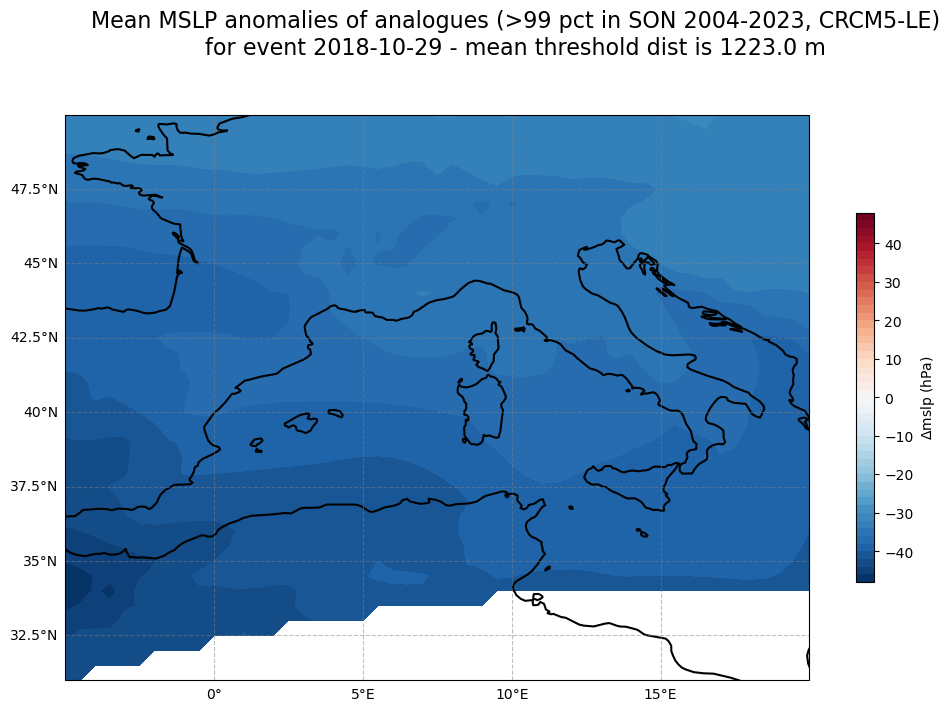

In [ ]:
# Plot LE analogue mean
fig, ax = fanPM.plot_anom_event('mslp', dmslp_analogues_membmean_LE.lon, dmslp_analogues_membmean_LE.lat, dmslp_analogues_membmean_LE.mean(dim='member'), clim_analogues_LE.mean(dim='member').values) #
fig.suptitle("Mean MSLP anomalies of analogues (>"+str(int(qtl_LE*100))+" pct in "+str_months+' '+str(year_range[0])+'-'+str(year_range[1])+", CRCM5-LE)\nfor event "+str(time_event)[:10]+\
             " - mean threshold dist is "+str(np.round(thresh_LE.mean()))+' m', fontsize=16)
fig.show()
fig.savefig(fig_dir+'analogues-mslp_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_mean_'+str(int(qtl_LE*100))+'pct_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE.png')

## Compare threshold distance (ERA5 vs CRCM5-LE analogues)

NameError: name 'thresh' is not defined

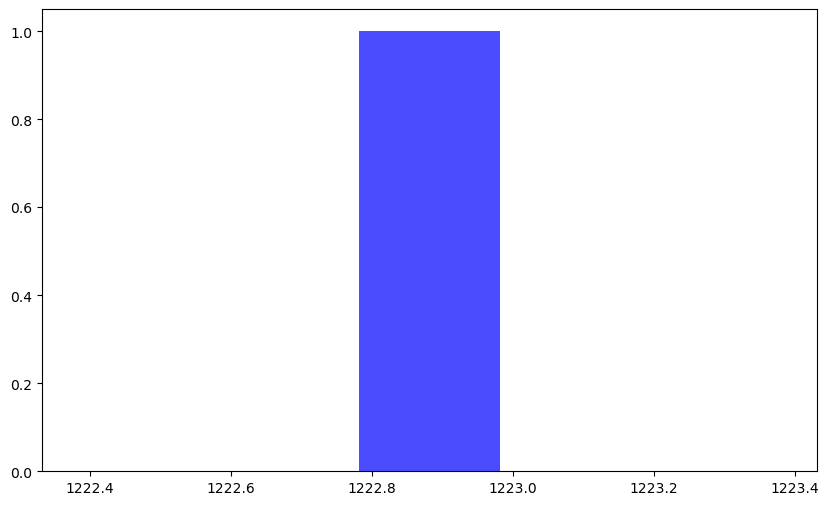

In [23]:
# Figure to compare thresh value to distribution of thresh_LE
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(thresh_LE, bins=5, color='blue', alpha=0.7, label='Thresholds from LE analogues')
ax.axvline(thresh, color='red', linestyle='--', label='Threshold from ERA5 analogues')
ax.set_xlabel('Threshold distance (m)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Threshold Distances from LE Analogues')
ax.legend()
fig.show()